# Generating SQL for SQLite using Ollama, ChromaDB
This notebook runs through the process of using the `vanna` Python package to generate SQL using AI (RAG + LLMs) including connecting to a database and training. If you're not ready to train on your own database, you can still try it using a sample [SQLite database](app.md).

## Setup

In [1]:
from api_key_store import ApiKeyStore
api_key = ApiKeyStore().get_api_key("ANTHROPIC")
# print(openai_api_key)

In [2]:
import warnings
import re

warnings.filterwarnings('ignore', category=DeprecationWarning, message='^Number of requested results')
# warnings.filterwarnings('ignore', category=DeprecationWarning, message=re.escape(r'^Some regex pattern'))

import os

import re
from time import time
from datetime import datetime 

# from vanna.ollama import Ollama
# from vanna.openai import OpenAI_Chat
# from vanna.google import GoogleGeminiChat
from vanna.anthropic import Anthropic_Chat
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore

In [3]:
model_name = 'claude-3-7-sonnet-latest' #  "claude-3-5-sonnet-20241022"  # "claude-3-sonnet-20240229"
# 'claude-sonnet-4-20250514' # is not good at generating SQL
file_db = "~/Downloads/chinook.sqlite"

CONFIG = {
    'model': model_name,   # 'mistral' # "starcoder2"
    'api_key': api_key,     
}

file_db = "~/Downloads/datasets/chinook.db"

clean_and_train = True  # False  

sql_id = 1
NUM_RETRY = 3

In [4]:
class MyVanna(ChromaDB_VectorStore, Anthropic_Chat):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        Anthropic_Chat.__init__(self, config=config)
        

In [5]:
def remove_collections(collection_name=None, ACCEPTED_TYPES = ["sql", "ddl", "documentation"]):
    if not collection_name:
        collections = ACCEPTED_TYPES
    elif isinstance(collection_name, str):
        collections = [collection_name]
    elif isinstance(collection_name, list):
        collections = collection_name
    else:
        print(f"\t{collection_name} is unknown: Skipped")
        return

    for c in collections:
        if not c in ACCEPTED_TYPES:
            print(f"\t{c} is unknown: Skipped")
            continue
            
        # print(f"vn.remove_collection('{c}')")
        vn.remove_collection(c)

def strip_brackets(ddl):
    """
    This function removes square brackets from table and column names in a DDL script.
    
    Args:
        ddl (str): The DDL script containing square brackets.
    
    Returns:
        str: The DDL script with square brackets removed.
    """
    # Use regular expressions to match and replace square brackets
    pattern = r"\[([^\]]+)]"  # Match any character except ] within square brackets
    return re.sub(pattern, r"\1", ddl)

In [6]:
vn = MyVanna(config=CONFIG)

In [7]:
hostname = os.uname().nodename
print("Hostname:", hostname)

Hostname: papa-game


In [8]:
file_db = os.path.abspath(os.path.expanduser(file_db))
vn.connect_to_sqlite(file_db)

In [9]:
vn.run_sql_is_set

True

## Training
You only need to train once. Do not train again unless you want to add more training data.

In [10]:
# show training data
training_data = vn.get_training_data()
training_data

,id,dataset,question,content,training_data_type
0,29a795c2-f536-548c-85b1-494e94c547c4-ddl,default,None,"CREATE TABLE ""albums""\r\n(\r\n AlbumId INTE...",ddl
1,4ce614e1-1af5-502f-a106-5c71bd49c66c-ddl,default,None,"CREATE TABLE sqlite_sequence(name,seq)",ddl
2,981a8f6a-292e-5da4-b8f6-c979b05f60b2-ddl,default,None,"CREATE TABLE ""artists""\r\n(\r\n ArtistId IN...",ddl
3,90d6de66-fbf7-52fd-bf7d-c39796669b7f-ddl,default,None,"CREATE TABLE ""customers""\r\n(\r\n CustomerI...",ddl
4,1323a585-b921-528b-a12c-54697d3801d3-ddl,default,None,"CREATE TABLE ""employees""\r\n(\r\n EmployeeI...",ddl
5,a8d77d80-5afb-5178-8491-a4ed1eb6112d-ddl,default,None,"CREATE TABLE ""genres""\r\n(\r\n GenreId INTE...",ddl
6,0f11423b-66c8-5ba4-8e59-2e4f617db70e-ddl,default,None,"CREATE TABLE ""invoices""\r\n(\r\n InvoiceId ...",ddl
7,90be1638-159a-51d4-b376-762b805aae91-ddl,default,None,"CREATE TABLE ""invoice_items""\r\n(\r\n Invoi...",ddl
8,039a70d7-499f-57e5-9cff-73e7c23dd2b3-ddl,default,None,"CREATE TABLE ""media_types""\r\n(\r\n MediaTy...",ddl
9,02ee8d00-a7dd-5598-b62b-e3a06084dbda-ddl,default,None,"CREATE TABLE ""playlists""\r\n(\r\n PlaylistI...",ddl


In [11]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [12]:
df_ddl

,type,sql
0,table,"CREATE TABLE ""albums""\r\n(\r\n [AlbumId] IN..."
1,table,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,"CREATE TABLE ""artists""\r\n(\r\n [ArtistId] ..."
3,table,"CREATE TABLE ""customers""\r\n(\r\n [Customer..."
4,table,"CREATE TABLE ""employees""\r\n(\r\n [Employee..."
5,table,"CREATE TABLE ""genres""\r\n(\r\n [GenreId] IN..."
6,table,"CREATE TABLE ""invoices""\r\n(\r\n [InvoiceId..."
7,table,"CREATE TABLE ""invoice_items""\r\n(\r\n [Invo..."
8,table,"CREATE TABLE ""media_types""\r\n(\r\n [MediaT..."
9,table,"CREATE TABLE ""playlists""\r\n(\r\n [Playlist..."


In [13]:
if clean_and_train:
    for ddl in df_ddl['sql'].to_list():
        ddl = strip_brackets(ddl)
        vn.train(ddl=ddl)

    # Sometimes you may want to add documentation about your business terminology or definitions.
    vn.train(documentation="In the chinook database invoice means order")

Add of existing embedding ID: 29a795c2-f536-548c-85b1-494e94c547c4-ddl
Add of existing embedding ID: 4ce614e1-1af5-502f-a106-5c71bd49c66c-ddl
Add of existing embedding ID: 981a8f6a-292e-5da4-b8f6-c979b05f60b2-ddl
Add of existing embedding ID: 90d6de66-fbf7-52fd-bf7d-c39796669b7f-ddl
Add of existing embedding ID: 1323a585-b921-528b-a12c-54697d3801d3-ddl
Add of existing embedding ID: a8d77d80-5afb-5178-8491-a4ed1eb6112d-ddl
Add of existing embedding ID: 0f11423b-66c8-5ba4-8e59-2e4f617db70e-ddl
Add of existing embedding ID: 90be1638-159a-51d4-b376-762b805aae91-ddl
Add of existing embedding ID: 039a70d7-499f-57e5-9cff-73e7c23dd2b3-ddl
Add of existing embedding ID: 02ee8d00-a7dd-5598-b62b-e3a06084dbda-ddl
Add of existing embedding ID: 38197d19-a90b-5ebe-b51d-eeee8760b334-ddl
Add of existing embedding ID: 833f07cf-68a0-5ca8-afda-dcf56dd90d92-ddl
Add of existing embedding ID: c4ac6533-13e1-5879-bf15-9abf51e0c61c-ddl
Add of existing embedding ID: 1b4e1e26-6cfa-573b-94b7-055aa1257b40-ddl
Add of



Adding ddl: CREATE TABLE "albums"
(
    AlbumId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Title NVARCHAR(160)  NOT NULL,
    ArtistId INTEGER  NOT NULL,
    FOREIGN KEY (ArtistId) REFERENCES "artists" (ArtistId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)


Insert of existing embedding ID: 4ce614e1-1af5-502f-a106-5c71bd49c66c-ddl
Add of existing embedding ID: 4ce614e1-1af5-502f-a106-5c71bd49c66c-ddl
Insert of existing embedding ID: 981a8f6a-292e-5da4-b8f6-c979b05f60b2-ddl
Add of existing embedding ID: 981a8f6a-292e-5da4-b8f6-c979b05f60b2-ddl




Adding ddl: CREATE TABLE sqlite_sequence(name,seq)


Adding ddl: CREATE TABLE "artists"
(
    ArtistId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Name NVARCHAR(120)
)


Insert of existing embedding ID: 90d6de66-fbf7-52fd-bf7d-c39796669b7f-ddl
Add of existing embedding ID: 90d6de66-fbf7-52fd-bf7d-c39796669b7f-ddl
Insert of existing embedding ID: 1323a585-b921-528b-a12c-54697d3801d3-ddl
Add of existing embedding ID: 1323a585-b921-528b-a12c-54697d3801d3-ddl




Adding ddl: CREATE TABLE "customers"
(
    CustomerId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    FirstName NVARCHAR(40)  NOT NULL,
    LastName NVARCHAR(20)  NOT NULL,
    Company NVARCHAR(80),
    Address NVARCHAR(70),
    City NVARCHAR(40),
    State NVARCHAR(40),
    Country NVARCHAR(40),
    PostalCode NVARCHAR(10),
    Phone NVARCHAR(24),
    Fax NVARCHAR(24),
    Email NVARCHAR(60)  NOT NULL,
    SupportRepId INTEGER,
    FOREIGN KEY (SupportRepId) REFERENCES "employees" (EmployeeId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)


Adding ddl: CREATE TABLE "employees"
(
    EmployeeId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    LastName NVARCHAR(20)  NOT NULL,
    FirstName NVARCHAR(20)  NOT NULL,
    Title NVARCHAR(30),
    ReportsTo INTEGER,
    BirthDate DATETIME,
    HireDate DATETIME,
    Address NVARCHAR(70),
    City NVARCHAR(40),
    State NVARCHAR(40),
    Country NVARCHAR(40),
    PostalCode NVARCHAR(10),
    Phone NVARCHAR(24),
    Fax NVARCHAR(24),
    Email 

Insert of existing embedding ID: a8d77d80-5afb-5178-8491-a4ed1eb6112d-ddl
Add of existing embedding ID: a8d77d80-5afb-5178-8491-a4ed1eb6112d-ddl
Insert of existing embedding ID: 0f11423b-66c8-5ba4-8e59-2e4f617db70e-ddl
Add of existing embedding ID: 0f11423b-66c8-5ba4-8e59-2e4f617db70e-ddl




Adding ddl: CREATE TABLE "genres"
(
    GenreId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Name NVARCHAR(120)
)


Adding ddl: CREATE TABLE "invoices"
(
    InvoiceId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    CustomerId INTEGER  NOT NULL,
    InvoiceDate DATETIME  NOT NULL,
    BillingAddress NVARCHAR(70),
    BillingCity NVARCHAR(40),
    BillingState NVARCHAR(40),
    BillingCountry NVARCHAR(40),
    BillingPostalCode NVARCHAR(10),
    Total NUMERIC(10,2)  NOT NULL,
    FOREIGN KEY (CustomerId) REFERENCES "customers" (CustomerId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)


Insert of existing embedding ID: 90be1638-159a-51d4-b376-762b805aae91-ddl
Add of existing embedding ID: 90be1638-159a-51d4-b376-762b805aae91-ddl
Insert of existing embedding ID: 039a70d7-499f-57e5-9cff-73e7c23dd2b3-ddl
Add of existing embedding ID: 039a70d7-499f-57e5-9cff-73e7c23dd2b3-ddl




Adding ddl: CREATE TABLE "invoice_items"
(
    InvoiceLineId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    InvoiceId INTEGER  NOT NULL,
    TrackId INTEGER  NOT NULL,
    UnitPrice NUMERIC(10,2)  NOT NULL,
    Quantity INTEGER  NOT NULL,
    FOREIGN KEY (InvoiceId) REFERENCES "invoices" (InvoiceId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION,
    FOREIGN KEY (TrackId) REFERENCES "tracks" (TrackId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)


Adding ddl: CREATE TABLE "media_types"
(
    MediaTypeId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Name NVARCHAR(120)
)


Insert of existing embedding ID: 02ee8d00-a7dd-5598-b62b-e3a06084dbda-ddl
Add of existing embedding ID: 02ee8d00-a7dd-5598-b62b-e3a06084dbda-ddl
Insert of existing embedding ID: 38197d19-a90b-5ebe-b51d-eeee8760b334-ddl
Add of existing embedding ID: 38197d19-a90b-5ebe-b51d-eeee8760b334-ddl




Adding ddl: CREATE TABLE "playlists"
(
    PlaylistId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Name NVARCHAR(120)
)


Adding ddl: CREATE TABLE "playlist_track"
(
    PlaylistId INTEGER  NOT NULL,
    TrackId INTEGER  NOT NULL,
    CONSTRAINT PK_PlaylistTrack PRIMARY KEY  (PlaylistId, TrackId),
    FOREIGN KEY (PlaylistId) REFERENCES "playlists" (PlaylistId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION,
    FOREIGN KEY (TrackId) REFERENCES "tracks" (TrackId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)


Insert of existing embedding ID: 833f07cf-68a0-5ca8-afda-dcf56dd90d92-ddl
Add of existing embedding ID: 833f07cf-68a0-5ca8-afda-dcf56dd90d92-ddl




Adding ddl: CREATE TABLE "tracks"
(
    TrackId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Name NVARCHAR(200)  NOT NULL,
    AlbumId INTEGER,
    MediaTypeId INTEGER  NOT NULL,
    GenreId INTEGER,
    Composer NVARCHAR(220),
    Milliseconds INTEGER  NOT NULL,
    Bytes INTEGER,
    UnitPrice NUMERIC(10,2)  NOT NULL,
    FOREIGN KEY (AlbumId) REFERENCES "albums" (AlbumId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION,
    FOREIGN KEY (GenreId) REFERENCES "genres" (GenreId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION,
    FOREIGN KEY (MediaTypeId) REFERENCES "media_types" (MediaTypeId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)


Adding ddl: CREATE INDEX IFK_AlbumArtistId ON "albums" (ArtistId)


Insert of existing embedding ID: c4ac6533-13e1-5879-bf15-9abf51e0c61c-ddl
Add of existing embedding ID: c4ac6533-13e1-5879-bf15-9abf51e0c61c-ddl
Insert of existing embedding ID: 1b4e1e26-6cfa-573b-94b7-055aa1257b40-ddl
Add of existing embedding ID: 1b4e1e26-6cfa-573b-94b7-055aa1257b40-ddl




Adding ddl: CREATE INDEX IFK_CustomerSupportRepId ON "customers" (SupportRepId)


Insert of existing embedding ID: 020848a7-bac7-53cf-9af9-ca0f8e540216-ddl
Add of existing embedding ID: 020848a7-bac7-53cf-9af9-ca0f8e540216-ddl




Adding ddl: CREATE INDEX IFK_EmployeeReportsTo ON "employees" (ReportsTo)


Adding ddl: CREATE INDEX IFK_InvoiceCustomerId ON "invoices" (CustomerId)


Insert of existing embedding ID: a9a6eea5-de78-5fc3-8650-31d9b258fda6-ddl
Add of existing embedding ID: a9a6eea5-de78-5fc3-8650-31d9b258fda6-ddl
Insert of existing embedding ID: 58dac216-497c-5225-8d22-b59885250762-ddl
Add of existing embedding ID: 58dac216-497c-5225-8d22-b59885250762-ddl
Insert of existing embedding ID: 4dc745a8-375e-51c7-b9cb-e93f6b179882-ddl
Add of existing embedding ID: 4dc745a8-375e-51c7-b9cb-e93f6b179882-ddl
Insert of existing embedding ID: bb5b15de-95e3-5a54-bf49-a808285bc886-ddl
Add of existing embedding ID: bb5b15de-95e3-5a54-bf49-a808285bc886-ddl




Adding ddl: CREATE INDEX IFK_InvoiceLineInvoiceId ON "invoice_items" (InvoiceId)


Adding ddl: CREATE INDEX IFK_InvoiceLineTrackId ON "invoice_items" (TrackId)


Adding ddl: CREATE INDEX IFK_PlaylistTrackTrackId ON "playlist_track" (TrackId)


Insert of existing embedding ID: 4bbdce6c-4cbd-53a7-98d6-455b65c23f1c-ddl
Add of existing embedding ID: 4bbdce6c-4cbd-53a7-98d6-455b65c23f1c-ddl
Insert of existing embedding ID: cec55741-f7e6-50f6-ace5-f7ee61430d57-ddl
Add of existing embedding ID: cec55741-f7e6-50f6-ace5-f7ee61430d57-ddl




Adding ddl: CREATE INDEX IFK_TrackAlbumId ON "tracks" (AlbumId)


Adding ddl: CREATE INDEX IFK_TrackGenreId ON "tracks" (GenreId)


Insert of existing embedding ID: 88d03b79-b19b-5851-a54e-4650cd084666-ddl
Add of existing embedding ID: 88d03b79-b19b-5851-a54e-4650cd084666-ddl




Adding ddl: CREATE INDEX IFK_TrackMediaTypeId ON "tracks" (MediaTypeId)


Adding ddl: CREATE TABLE sqlite_stat1(tbl,idx,stat)


Insert of existing embedding ID: 93908e71-4aa4-5332-b504-7749472931a8-ddl
Add of existing embedding ID: 93908e71-4aa4-5332-b504-7749472931a8-ddl
Insert of existing embedding ID: e2cdfd36-5040-5cc6-82cc-24af4c8ec105-doc
Add of existing embedding ID: e2cdfd36-5040-5cc6-82cc-24af4c8ec105-doc




Adding documentation....


## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

### warm-up





# QUESTION :  How many customers are there


Using model claude-3-7-sonnet-latest for 7.0 tokens (approx)

[( RETRY )]
***** 1 *****

Using model claude-3-7-sonnet-latest for 164.0 tokens (approx)

[( EXTRACTED SQL )]
SELECT COUNT(*) AS total_customers
FROM customers;


[( <SQL> )]
generated SQL statement



SELECT COUNT(*) AS total_customers
FROM customers;


[( <DataFrame> )]
queried dataframe



,total_customers
0,59


Using model claude-3-7-sonnet-latest for 377.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    mode="number",
    value=df['total_customers'].iloc[0],
    title={"text": "Total Customers"}
))

fig.update_layout(
    height=300,
    width=500
)

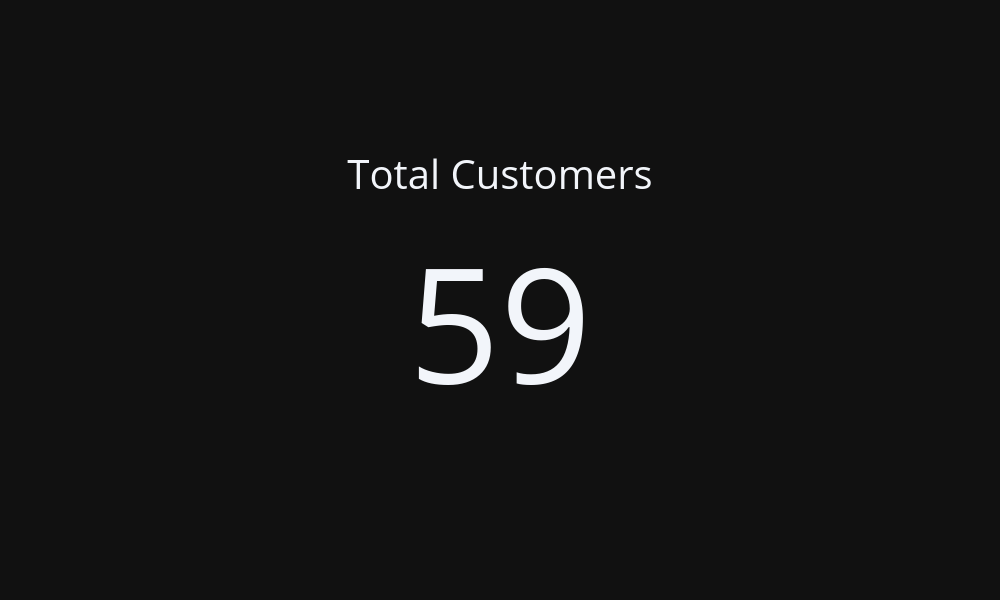

elapsed_time = 11.60901403427124


In [10]:
ts_start = time()
question = "How many customers are there"
resp = vn.ask_adaptive(question=question)
ts_stop = time()
elapsed_time = ts_stop - ts_start
print(f"elapsed_time = {elapsed_time}")

In [11]:
### Loop over questions

In [12]:
questions = [
    "Can you list all tables in the SQLite database catalog?",
    "which table stores customer's orders",
    "How many customers are there",
    "what are the top 5 countries that customers come from?",
    "List all albums and their corresponding artist names  ",
    """Find all tracks with a name containing "What" (case-insensitive) """,
    "Get the total number of invoices for each customer",
    "Find the total number of invoices per country",
    "List all invoices with a total exceeding $10",
    "Find all invoices since 2010 and the total amount invoiced:",
    "List all employees and their reporting manager's name (if any):",
    " Get the average invoice total for each customer:",
    "Find the top 5 most expensive tracks (based on unit price):",
    "List all genres and the number of tracks in each genre:",
    "Get all genres that do not have any tracks associated with them:",
    "List all customers who have not placed any orders:",
    """ 
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    """,
    "List all customers from Canada and their email addresses:",
    "Find the customer with the most invoices ",
    "Find the customer who bought the most albums in total quantity (across all invoices):",
    """      
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    """,
    """  
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    """,
    "Get all playlists containing at least 10 tracks and the total duration of those tracks:",
    "Identify artists who have albums with tracks appearing in multiple genres:",
]





# QUESTION  - 2:  Can you list all tables in the SQLite database catalog?


Using model claude-3-7-sonnet-latest for 13.75 tokens (approx)

[( EXTRACTED SQL )]
SELECT name FROM sqlite_master 
WHERE type='table'
ORDER BY name;
```

This query returns the names of all user-created tables in the database. If you want to exclude SQLite's internal tables (which typically start 

```sql
SELECT name FROM sqlite_master 
WHERE type='table' AND name NOT LIKE 'sqlite_%'
ORDER BY name;


[( <SQL> )]
generated SQL statement



SELECT name FROM sqlite_master 
WHERE type='table'
ORDER BY name;
```

This query returns the names of all user-created tables in the database. If you want to exclude SQLite's internal tables (which typically start 

```sql
SELECT name FROM sqlite_master 
WHERE type='table' AND name NOT LIKE 'sqlite_%'
ORDER BY name;


[( RETRY )]
***** 1 *****

Using model claude-3-7-sonnet-latest for 256.75 tokens (approx)

[( EXTRACTED SQL )]
SELECT name FROM sqlite_master 
WHERE type='table'
ORDER BY name;
```

If you want to exclude SQLite's internal tables (which typically start 

```sql
SELECT name FROM sqlite_master 
WHERE type='table' AND name NOT LIKE 'sqlite_%'
ORDER BY name;
```

And if you want to limit the results to 20 tables:

```sql
SELECT name FROM sqlite_master 
WHERE type='table' AND name NOT LIKE 'sqlite_%'
ORDER BY name 
LIMIT 20;


[( <SQL> )]
generated SQL statement



SELECT name FROM sqlite_master 
WHERE type='table'
ORDER BY name;
```

If you want to exclude SQLite's internal tables (which typically start 

```sql
SELECT name FROM sqlite_master 
WHERE type='table' AND name NOT LIKE 'sqlite_%'
ORDER BY name;
```

And if you want to limit the results to 20 tables:

```sql
SELECT name FROM sqlite_master 
WHERE type='table' AND name NOT LIKE 'sqlite_%'
ORDER BY name 
LIMIT 20;


[( RETRY )]
***** 2 *****

Using model claude-3-7-sonnet-latest for 499.75 tokens (approx)

[( EXTRACTED SQL )]
SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;
```

If you want to exclude SQLite's internal tables (which typically start 

```sql
SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%' ORDER BY name;


[( <SQL> )]
generated SQL statement



SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;
```

If you want to exclude SQLite's internal tables (which typically start 

```sql
SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%' ORDER BY name;


[( RETRY )]
***** 3 *****

Using model claude-3-7-sonnet-latest for 742.75 tokens (approx)

[( EXTRACTED SQL )]
SELECT name 
FROM sqlite_master 
WHERE type='table' 
ORDER BY name;
```

If you want to exclude SQLite's internal tables (which typically start 

```sql
SELECT name 
FROM sqlite_master 
WHERE type='table' AND name NOT LIKE 'sqlite_%'
ORDER BY name;
```

To limit the results to 20 tables:

```sql
SELECT name 
FROM sqlite_master 
WHERE type='table' 
ORDER BY name 
LIMIT 20;


[( <SQL> )]
generated SQL statement



SELECT name 
FROM sqlite_master 
WHERE type='table' 
ORDER BY name;
```

If you want to exclude SQLite's internal tables (which typically start 

```sql
SELECT name 
FROM sqlite_master 
WHERE type='table' AND name NOT LIKE 'sqlite_%'
ORDER BY name;
```

To limit the results to 20 tables:

```sql
SELECT name 
FROM sqlite_master 
WHERE type='table' 
ORDER BY name 
LIMIT 20;





# QUESTION  - 3:  which table stores customer's orders


Using model claude-3-7-sonnet-latest for 9.0 tokens (approx)

[( RETRY )]
***** 1 *****

Using model claude-3-7-sonnet-latest for 257.0 tokens (approx)

[( EXTRACTED SQL )]
SELECT 
    table_name 
FROM 
    information_schema.tables 
WHERE 
    table_name LIKE '%order%' 
    OR table_name LIKE '%sale%' 
    OR table_name LIKE '%purchase%' 
    OR table_name LIKE '%transaction%'
ORDER BY 
    table_name;
```

This query searches the database metadata for tables 

```sql
SELECT 
    column_name, data_type 
FROM 
    information_schema.columns 
WHERE 
    table_name = 'orders';  -- Replace 'orders' with the table name you want to inspect


[( <SQL> )]
generated SQL statement



SELECT 
    table_name 
FROM 
    information_schema.tables 
WHERE 
    table_name LIKE '%order%' 
    OR table_name LIKE '%sale%' 
    OR table_name LIKE '%purchase%' 
    OR table_name LIKE '%transaction%'
ORDER BY 
    table_name;
```

This query searches the database metadata for tables 

```sql
SELECT 
    column_name, data_type 
FROM 
    information_schema.columns 
WHERE 
    table_name = 'orders';  -- Replace 'orders' with the table name you want to inspect


[( RETRY )]
***** 2 *****

Using model claude-3-7-sonnet-latest for 505.0 tokens (approx)

[( EXTRACTED SQL )]
SELECT 
    table_name
FROM 
    information_schema.tables
WHERE 
    table_name LIKE '%order%' 
    OR table_name LIKE '%sale%'
    OR table_name LIKE '%purchase%'
    OR table_name LIKE '%transaction%'
    OR table_name LIKE '%invoice%'
ORDER BY 
    table_name;


[( <SQL> )]
generated SQL statement



SELECT 
    table_name
FROM 
    information_schema.tables
WHERE 
    table_name LIKE '%order%' 
    OR table_name LIKE '%sale%'
    OR table_name LIKE '%purchase%'
    OR table_name LIKE '%transaction%'
    OR table_name LIKE '%invoice%'
ORDER BY 
    table_name;


[( RETRY )]
***** 3 *****

Using model claude-3-7-sonnet-latest for 753.0 tokens (approx)

[( EXTRACTED SQL )]
SELECT 
    table_name
FROM 
    information_schema.tables
WHERE 
    table_name LIKE '%order%' 
    OR table_name LIKE '%customer%order%'
    OR table_name LIKE '%purchase%'
    OR table_name LIKE '%transaction%'
ORDER BY 
    table_name;


[( <SQL> )]
generated SQL statement



SELECT 
    table_name
FROM 
    information_schema.tables
WHERE 
    table_name LIKE '%order%' 
    OR table_name LIKE '%customer%order%'
    OR table_name LIKE '%purchase%'
    OR table_name LIKE '%transaction%'
ORDER BY 
    table_name;





# QUESTION  - 4:  How many customers are there


Using model claude-3-7-sonnet-latest for 7.0 tokens (approx)

[( RETRY )]
***** 1 *****

Using model claude-3-7-sonnet-latest for 186.25 tokens (approx)

[( EXTRACTED SQL )]
SELECT COUNT(*) AS total_customers
FROM customers;


[( <SQL> )]
generated SQL statement



SELECT COUNT(*) AS total_customers
FROM customers;


[( <DataFrame> )]
queried dataframe



,total_customers
0,59


Using model claude-3-7-sonnet-latest for 399.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    mode="number",
    value=df['total_customers'].iloc[0],
    title={"text": "Total Customers"}
))

fig.update_layout(
    height=300,
    width=500
)

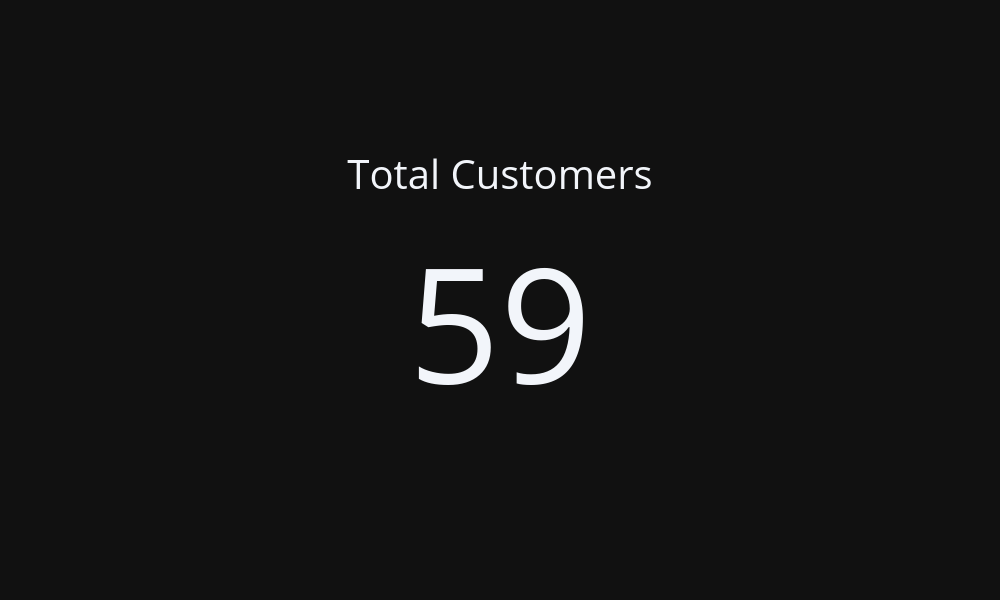





# QUESTION  - 5:  what are the top 5 countries that customers come from?


Using model claude-3-7-sonnet-latest for 13.5 tokens (approx)

[( RETRY )]
***** 1 *****

Using model claude-3-7-sonnet-latest for 257.25 tokens (approx)

[( EXTRACTED SQL )]
SELECT country, COUNT(*) as customer_count
FROM customers
GROUP BY country
ORDER BY customer_count DESC
LIMIT 5;


[( <SQL> )]
generated SQL statement



SELECT country, COUNT(*) as customer_count
FROM customers
GROUP BY country
ORDER BY customer_count DESC
LIMIT 5;


[( <DataFrame> )]
queried dataframe



,Country,customer_count
0,USA,13
1,Canada,8
2,France,5
3,Brazil,5
4,Germany,4


Using model claude-3-7-sonnet-latest for 490.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px

fig = px.bar(df, x='Country', y='customer_count', 
             title='Top 5 Countries by Customer Count',
             labels={'Country': 'Country', 'customer_count': 'Number of Customers'},
             color='customer_count',
             color_continuous_scale='Blues')

fig.update_layout(
    xaxis_title='Country',
    yaxis_title='Number of Customers',
    coloraxis_showscale=False
)

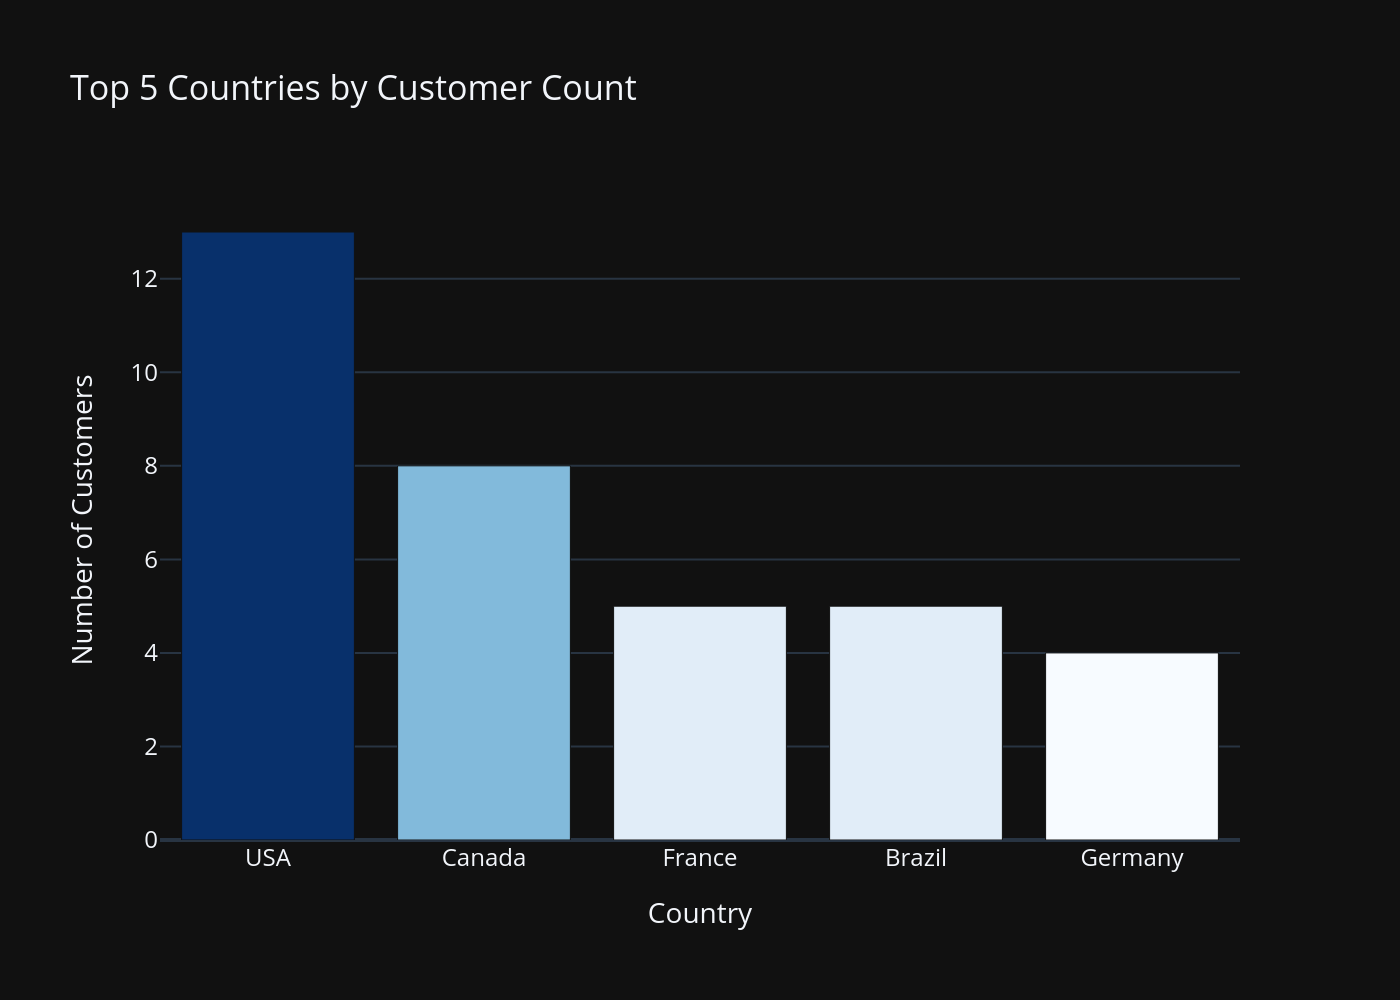





# QUESTION  - 6:  List all albums and their corresponding artist names  


Using model claude-3-7-sonnet-latest for 13.5 tokens (approx)

[( RETRY )]
***** 1 *****

Using model claude-3-7-sonnet-latest for 312.0 tokens (approx)

[( EXTRACTED SQL )]
SELECT 
    albums.title AS album_name,
    artists.name AS artist_name
FROM 
    albums
JOIN 
    artists ON albums.artist_id = artists.id
ORDER BY 
    artists.name, albums.title;


[( <SQL> )]
generated SQL statement



SELECT 
    albums.title AS album_name,
    artists.name AS artist_name
FROM 
    albums
JOIN 
    artists ON albums.artist_id = artists.id
ORDER BY 
    artists.name, albums.title;


[( RETRY )]
***** 2 *****

Using model claude-3-7-sonnet-latest for 610.5 tokens (approx)

[( EXTRACTED SQL )]
SELECT 
    albums.title AS album_title,
    artists.name AS artist_name
FROM 
    albums
JOIN 
    artists ON albums.artist_id = artists.id
ORDER BY 
    artists.name, albums.title;


[( <SQL> )]
generated SQL statement



SELECT 
    albums.title AS album_title,
    artists.name AS artist_name
FROM 
    albums
JOIN 
    artists ON albums.artist_id = artists.id
ORDER BY 
    artists.name, albums.title;


[( RETRY )]
***** 3 *****

Using model claude-3-7-sonnet-latest for 909.0 tokens (approx)

[( EXTRACTED SQL )]
SELECT 
    albums.title AS album_title,
    artists.name AS artist_name
FROM 
    albums
JOIN 
    artists ON albums.artist_id = artists.id
ORDER BY 
    artists.name, albums.title;


[( <SQL> )]
generated SQL statement



SELECT 
    albums.title AS album_title,
    artists.name AS artist_name
FROM 
    albums
JOIN 
    artists ON albums.artist_id = artists.id
ORDER BY 
    artists.name, albums.title;





# QUESTION  - 7:  Find all tracks with a name containing "What" (case-insensitive) 


Using model claude-3-7-sonnet-latest for 16.25 tokens (approx)

[( EXTRACTED SQL )]
SELECT 
    TrackId,
    Name,
    Composer,
    Milliseconds,
    Bytes,
    UnitPrice
FROM 
    Track
WHERE 
    LOWER(Name) LIKE '%what%'
ORDER BY 
    Name;


[( <SQL> )]
generated SQL statement



SELECT 
    TrackId,
    Name,
    Composer,
    Milliseconds,
    Bytes,
    UnitPrice
FROM 
    Track
WHERE 
    LOWER(Name) LIKE '%what%'
ORDER BY 
    Name;


[( RETRY )]
***** 1 *****

Using model claude-3-7-sonnet-latest for 174.0 tokens (approx)

[( EXTRACTED SQL )]
SELECT 
    TrackId,
    Name,
    Composer,
    Milliseconds,
    Bytes,
    UnitPrice
FROM 
    tracks
WHERE 
    LOWER(Name) LIKE '%what%'
ORDER BY 
    Name 
LIMIT 20


[( <SQL> )]
generated SQL statement



SELECT 
    TrackId,
    Name,
    Composer,
    Milliseconds,
    Bytes,
    UnitPrice
FROM 
    tracks
WHERE 
    LOWER(Name) LIKE '%what%'
ORDER BY 
    Name 
LIMIT 20


[( <DataFrame> )]
queried dataframe



,TrackId,Name,Composer,Milliseconds,Bytes,UnitPrice
0,130,Do what cha wanna,George Duke,274155,9018565,0.99
1,1470,Get What You Need,C. Cester/C. Muncey/N. Cester,247719,8043765,0.99
2,2772,I Don't Know What To Do With Myself,None,221387,7251478,0.99
3,3007,I Still Haven't Found What I'm Looking For,U2,280764,9306737,0.99
4,2992,I Still Haven't Found What I'm Looking for,"Bono/Clayton, Adam/Mullen Jr., Larry/The Edge",353567,11542247,0.99
5,1469,Look What You've Done,N. Cester,230974,7517083,0.99
6,607,So What,Miles Davis,564009,18360449,0.99
7,1823,So What,Culmer/Exalt,189152,6162894,0.99
8,960,What A Day,"Mike Bordin, Billy Gould, Mike Patton",158275,5203430,0.99
9,1000,What If I Do?,"Dave Grohl, Taylor Hawkins, Nate Mendel, Chris...",302994,9929799,0.99


Using model claude-3-7-sonnet-latest for 445.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import pandas as pd

# Ensure df is limited to 20 rows
df_plot = df.head(20)

# Create a bar chart of track names and their durations
fig = px.bar(
    df_plot,
    x='Name',
    y='Milliseconds',
    hover_data=['Composer', 'UnitPrice'],
    labels={'Milliseconds': 'Duration (ms)', 'Name': 'Track Name'},
    title='Tracks Containing "What" - Duration Comparison',
    color='UnitPrice',
    color_continuous_scale='Viridis'
)

# Improve layout
fig.update_layout(
    xaxis_tickangle=-45,
    height=600,
    width=1000
)

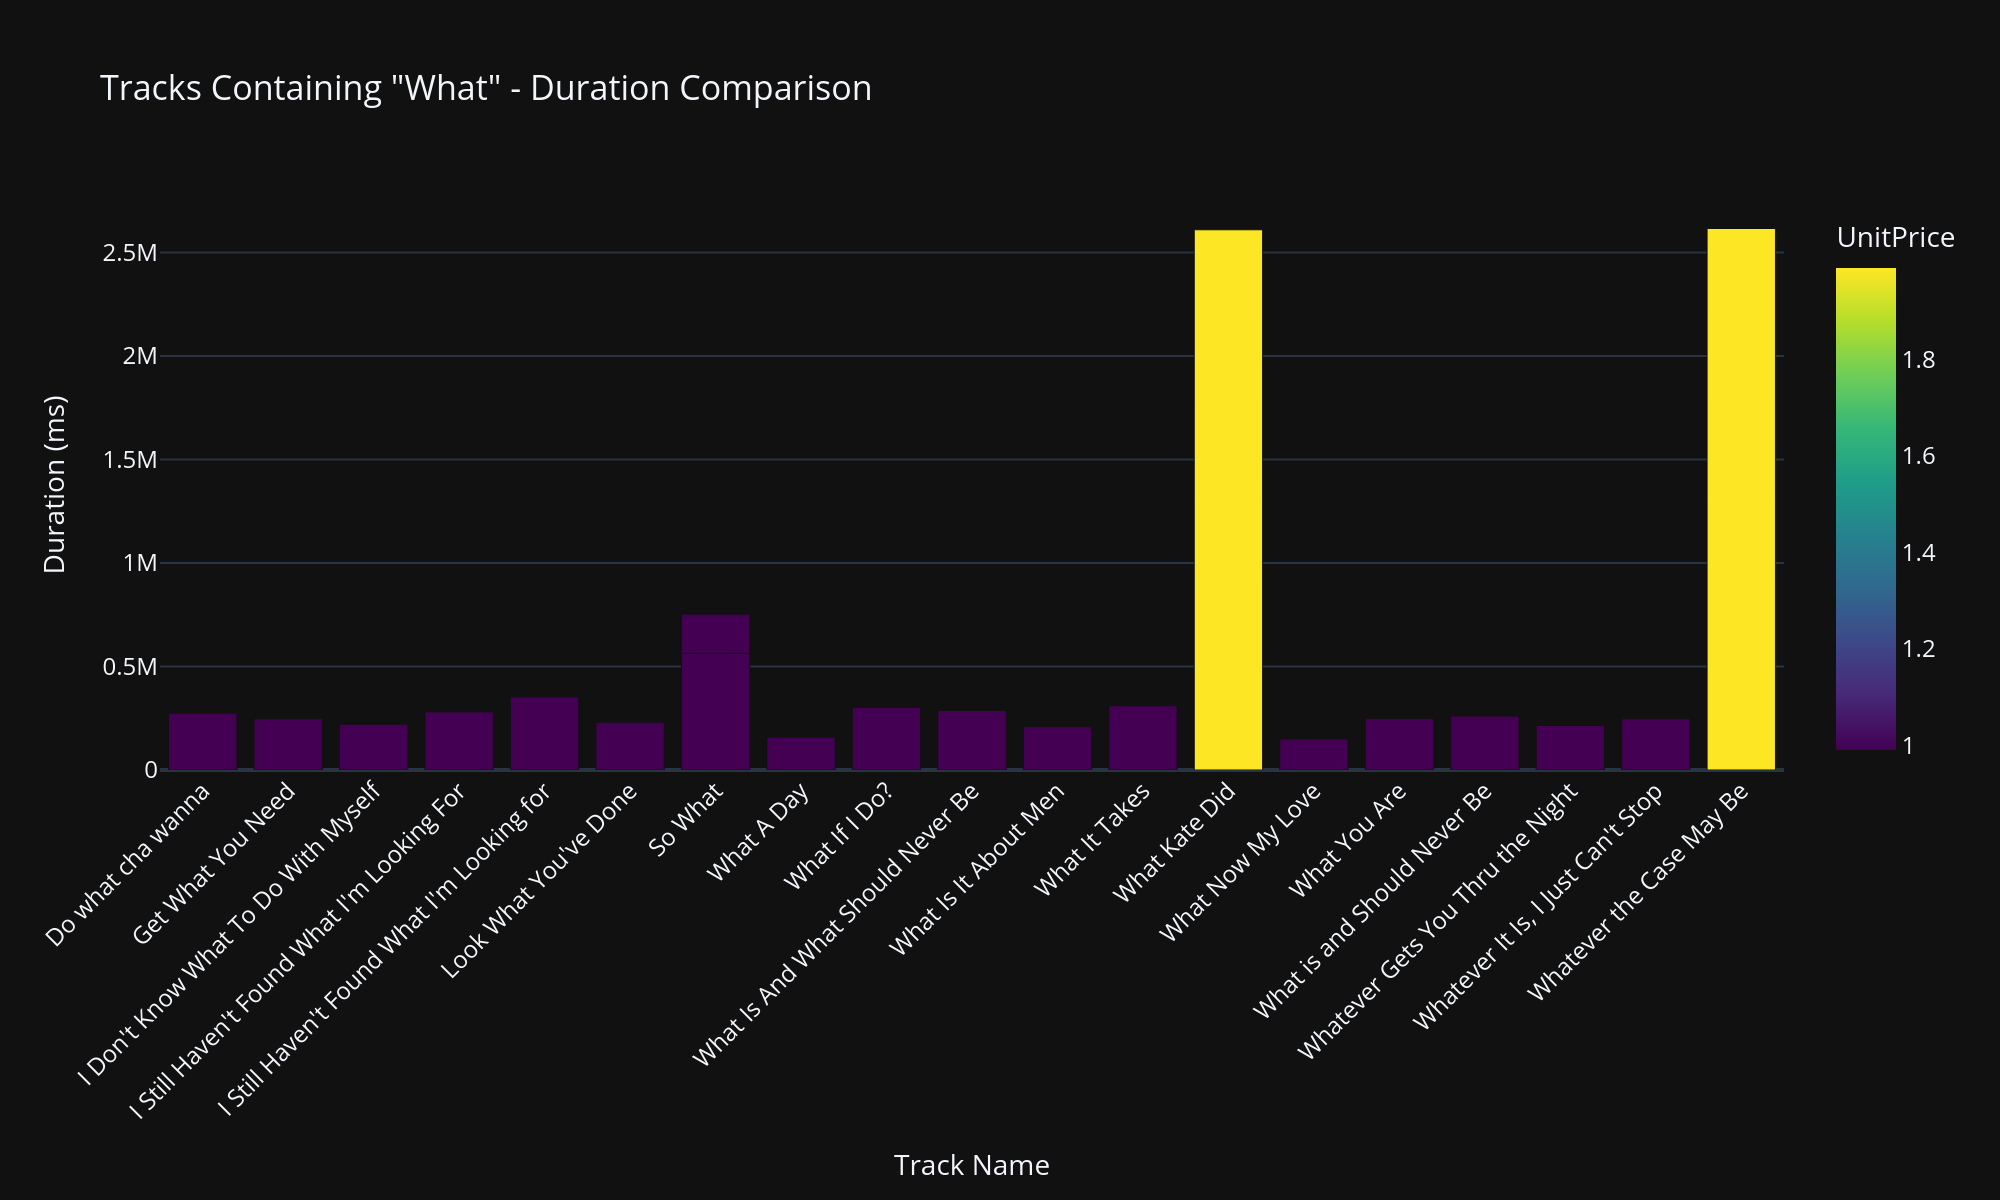

In [13]:
ts_start = time()
for n, question in enumerate(questions):
    # if n != 4: continue
    if n > 5: continue

    resp = vn.ask_adaptive(question=question, tag_id=n+2)
    # vn.ask(question=question, allow_llm_to_see_data=allow_llm_to_see_data)
    # my_vn_ask(question=question, sql_id=n+2, allow_llm_to_see_data=allow_llm_to_see_data)

ts_stop = time()
elapsed_time = ts_stop - ts_start

## Check completion time

In [19]:
str_elapsed_sec = f"{elapsed_time:.0f}"
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
print(f"Completed testing:\n================\n LLM model '{model_name}' \n took {str_elapsed_sec} sec\n run on '{hostname}' \n at {ts}")

Completed testing:
 LLM model 'claude-3-5-sonnet-20241022' 
 took 149 sec
 run on 'ducklover1' 
 at 20241122-232143


In [20]:
file_csv = f"training_data-{model_name}-{str_elapsed_sec}s-{hostname}-{ts}.csv"
file_csv

'training_data-claude-3-5-sonnet-20241022-149s-ducklover1-20241122-232143.csv'

### Save training data

In [21]:
# show training data
df_training_data = vn.get_training_data()
df_training_data

,id,question,content,training_data_type
0,12dd59f0-d021-5c6d-a453-190e908eae78-sql,List all invoices with a total exceeding $10,"SELECT InvoiceId, CustomerId, InvoiceDate, Tot...",sql
1,239975a3-a817-5e85-bf5c-da2a315545ec-sql,List all customers from Canada and their email...,"SELECT FirstName, LastName, Email\nFROM custom...",sql
2,3b38f7cc-48b3-5679-86f7-ccd7d00ef1c2-sql,\n Find the top 5 customers who b...,"SELECT c.CustomerId, \n c.FirstName, \n ...",sql
3,3ed67005-3b35-5b85-85a5-a0256ecb4b33-sql,List all genres and the number of tracks in ea...,"SELECT g.Name as genre_name, \n COUNT(t....",sql
4,411d1ca7-609d-5ae7-ae0c-f9d618c51479-sql,List all albums and their corresponding artist...,"SELECT a.Title as album_title, ar.Name as arti...",sql
5,45ec8642-c9df-5f7c-9db7-a3e49ffeb99b-sql,Find all invoices since 2010 and the total amo...,"SELECT COUNT(*) as invoice_count, \n SUM...",sql
6,623f1c4c-8b2b-5bbf-a7c3-6d8aa4721624-sql,"Find all tracks with a name containing ""What"" ...",SELECT Name \nFROM tracks \nWHERE UPPER(Name) ...,sql
7,695e5b81-3c5e-5122-8ec5-e8d8835aa99a-sql,Get the average invoice total for each customer:,"SELECT c.CustomerId, \n c.FirstName, \n ...",sql
8,6cd9e404-f70d-5f77-882c-4718fce6ee6c-sql,\n Generating SQL for this ...,SELECT 'invoices' as table_name \nFROM sqlite_...,sql
9,6fd13857-bd8b-5214-a162-9a62d2484f30-sql,How many customers are there,SELECT COUNT(*) \nFROM customers LIMIT 20,sql


In [22]:
df_training_data.to_csv(file_csv, index=False)